In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
#Importar Dataframe que contiene el trabajo semanal en la linea de volúmenes
df_vols_trabajo_semanal = pd.read_excel('./dataframes/df_vols_trabajo_semanal.xlsx')

In [3]:
#Preparar dataset
df_exponential_smoothing = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_exponential_smoothing = df_exponential_smoothing.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo', 'Unnamed: 0'], axis=1)

#Predeciremos 4 meses (16 semanaas, por tanto se testean 16 semanas)
fecha_max = df_vols_trabajo_semanal['semana_primer_dia'].max()
fecha_limite = fecha_max - pd.Timedelta(weeks = 15)
df_exp_train = df_exponential_smoothing[df_exponential_smoothing['ds'] < pd.to_datetime(fecha_limite)]
df_exp_test = df_exponential_smoothing[df_exponential_smoothing['ds'] >= pd.to_datetime(fecha_limite)]

print('Cantidad datos entrenamiento: ' + str(len(df_exp_train)))
print('Cantidad datos test: ' + str(len(df_exp_test)))

Cantidad datos entrenamiento: 169
Cantidad datos test: 16


## Visualizacion de datos de train y test

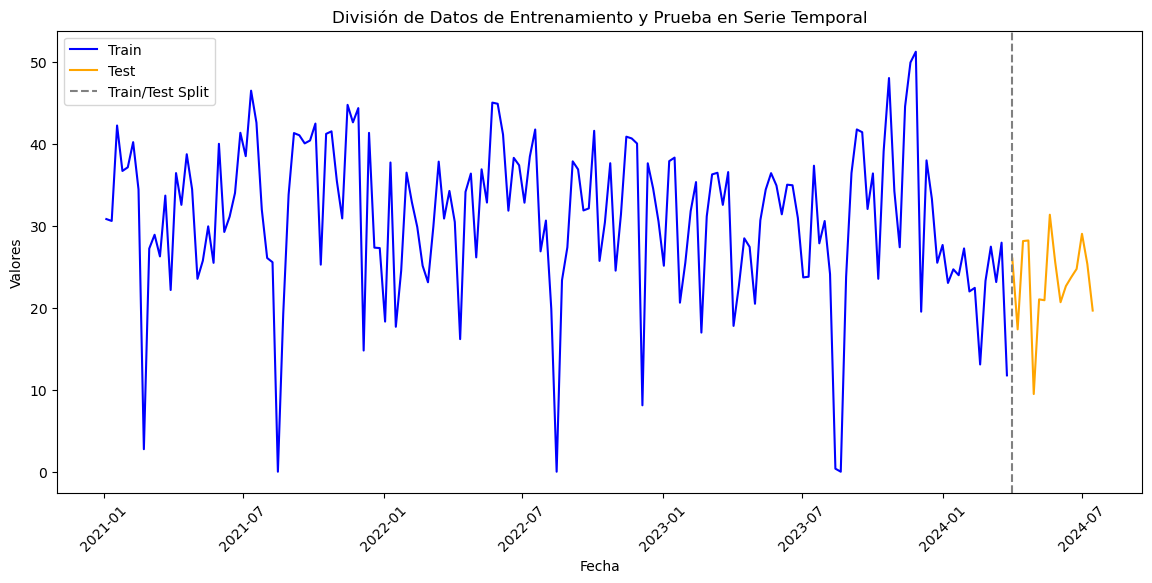

In [4]:
# Configuración de la figura
plt.figure(figsize=(14, 6))

# Graficar los datos de entrenamiento y prueba
sns.lineplot(data=df_exp_train, x='ds', y='y', label='Train', color='blue')
sns.lineplot(data=df_exp_test, x='ds', y='y', label='Test', color='orange')

# Agregar una línea vertical para indicar el punto de separación entre entrenamiento y prueba
plt.axvline(x=pd.to_datetime(fecha_limite), color='gray', linestyle='--', label='Train/Test Split')

# Configuraciones del gráfico
plt.title('División de Datos de Entrenamiento y Prueba en Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Ajuste iterativo de hiperparámetros

In [5]:
#Búsqueda de hiperparámetros para mejorar RMSE 
#NO FUNCIONA!!! SI SE USAN EN EL MODELO DE PREDICCION NO TIENE SENTIDO.!!!!

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

ITERATE = False

# Definir los valores para el grid search
param_grid = np.arange(0, 1.05, 0.01)  # Rango de 0 a 1 con pasos de 0.01

# Función para entrenar el modelo y calcular el RMSE
def evaluate_params(alpha, beta, gamma):
    model = ExponentialSmoothing(
        df_exp_train['y'], 
        trend='add', 
        seasonal='add', 
        seasonal_periods=52
    ).fit(
        smoothing_level=alpha,
        smoothing_slope=beta,
        smoothing_seasonal=gamma,
        optimized=False
    )

    # Predecir con el modelo ajustado
    y_pred_exp = model.forecast(16)

    # Calcular el RMSE
    rmse_exp = mean_squared_error(df_exp_test['y'], y_pred_exp) ** 0.5

    print(alpha, beta, gamma, rmse_exp)

    return (alpha, beta, gamma, rmse_exp)

if ITERATE:

    # Ejecutar la búsqueda en paralelo
    results = Parallel(n_jobs=-1)(delayed(evaluate_params)(alpha, beta, gamma)
                                  for alpha in param_grid
                                  for beta in param_grid
                                  for gamma in param_grid)

    # Identificar la mejor combinación de parámetros
    best_result = min(results, key=lambda x: x[3])
    best_alpha, best_beta, best_gamma, best_rmse = best_result

else:
    #calculado con salto 0.01, Trend, Seasonal = add, NO mul, 0.05 da igual resultado.
    best_alpha = 0.05
    best_beta = 0.3
    best_gamma = 0.2
    best_rmse = 4.37

# Imprimir los mejores parámetros y el RMSE correspondiente
print("Mejores parámetros encontrados para el modelo :")
print("Alpha:", best_alpha)
print("Beta:", best_beta)
print("Gamma:", best_gamma)
print("Mejor RMSE:", best_rmse)

Mejores parámetros encontrados para el modelo :
Alpha: 0.05
Beta: 0.3
Gamma: 0.2
Mejor RMSE: 4.37


RMSE: 4.372856443296525


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13252\3037219341.py:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(


<Axes: xlabel='ds', ylabel='y'>

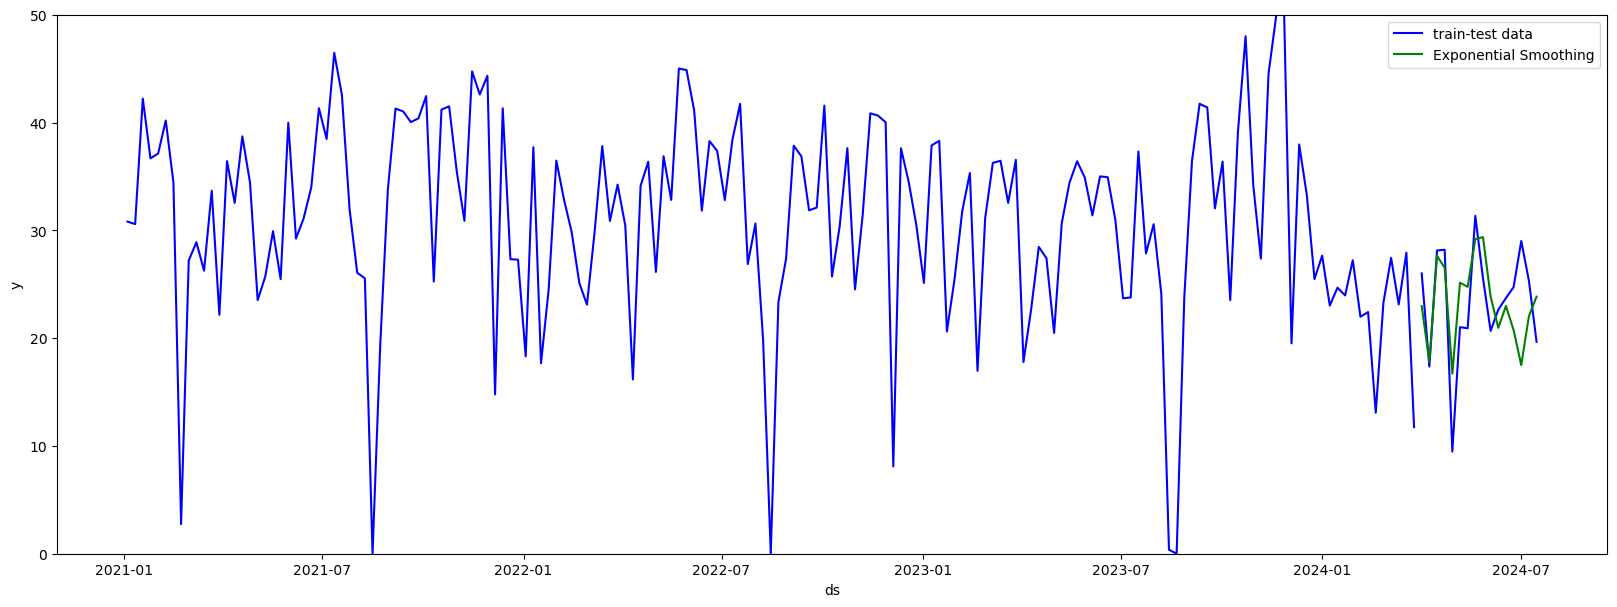

In [19]:
#Entrenar y realizar predicciones con los hiperparámetros calculados:
model = ExponentialSmoothing(
    df_exp_train['y'], 
    trend='add', #mul
    seasonal='add', #mul
    seasonal_periods=52
).fit(
    #Ajuste automático!!!!! No funciona ajuste iterativo ya que últimos valores cambian con nuevos datos.
    smoothing_level= best_alpha,  # Alpha
    smoothing_slope= best_beta,  # Beta
    smoothing_seasonal= best_gamma,  # Gamma
    optimized= False  # No optimizar automáticamente
)

y_pred_exp = model.forecast(16)

data = {
    'ds': df_exp_test['ds'],
    'yhat': y_pred_exp
}

y_pred_exp = pd.DataFrame(data)
rmse_exp = mean_squared_error(df_exp_test['y'], y_pred_exp['yhat']) ** (1/2)
print('RMSE: ' + str(rmse_exp))

#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
sns.lineplot(data = df_exp_train, x= 'ds', y= 'y', color = 'blue', label = 'train-test data')
sns.lineplot(data = df_exp_test, x= 'ds', y= 'y', color = 'blue')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'green', label = 'Exponential Smoothing')

suma de errores: 1.7225315417850027


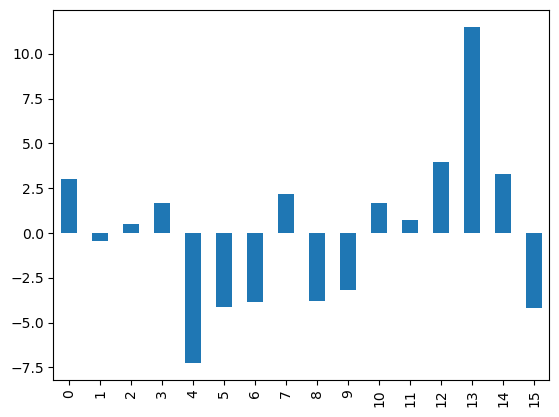

In [7]:
#Preparar dataset de comparación
df_forecast_comparison_exp = df_exp_test.merge(y_pred_exp, on= 'ds')
df_forecast_comparison_exp['error'] =  df_forecast_comparison_exp['y'] - df_forecast_comparison_exp['yhat']
#Parece centrado en 0. Buena señal
df_forecast_comparison_exp['error'].plot(kind = 'bar')
print('suma de errores: ' + str(df_forecast_comparison_exp['error'].sum()))

In [8]:
#Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print ('RMSE Exponential Smoothing: ' + str(mean_squared_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat']) ** (1/2)))
print ('MAE Exponential Smoothing: ' + str(mean_absolute_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat'])))
print ('MAPE Exponential Smoothing: ' + str(mean_absolute_percentage_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat'])))

RMSE Exponential Smoothing: 4.372856443296525
MAE Exponential Smoothing: 3.4595471247932066
MAPE Exponential Smoothing: 0.17123501465996627


### Predicción de valores futuros

In [9]:
last_date = fecha_max
future_dates = pd.date_range(start=last_date, periods=17, freq='W-MON')[1:]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13252\3644492542.py:5: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(


<Axes: xlabel='ds', ylabel='y'>

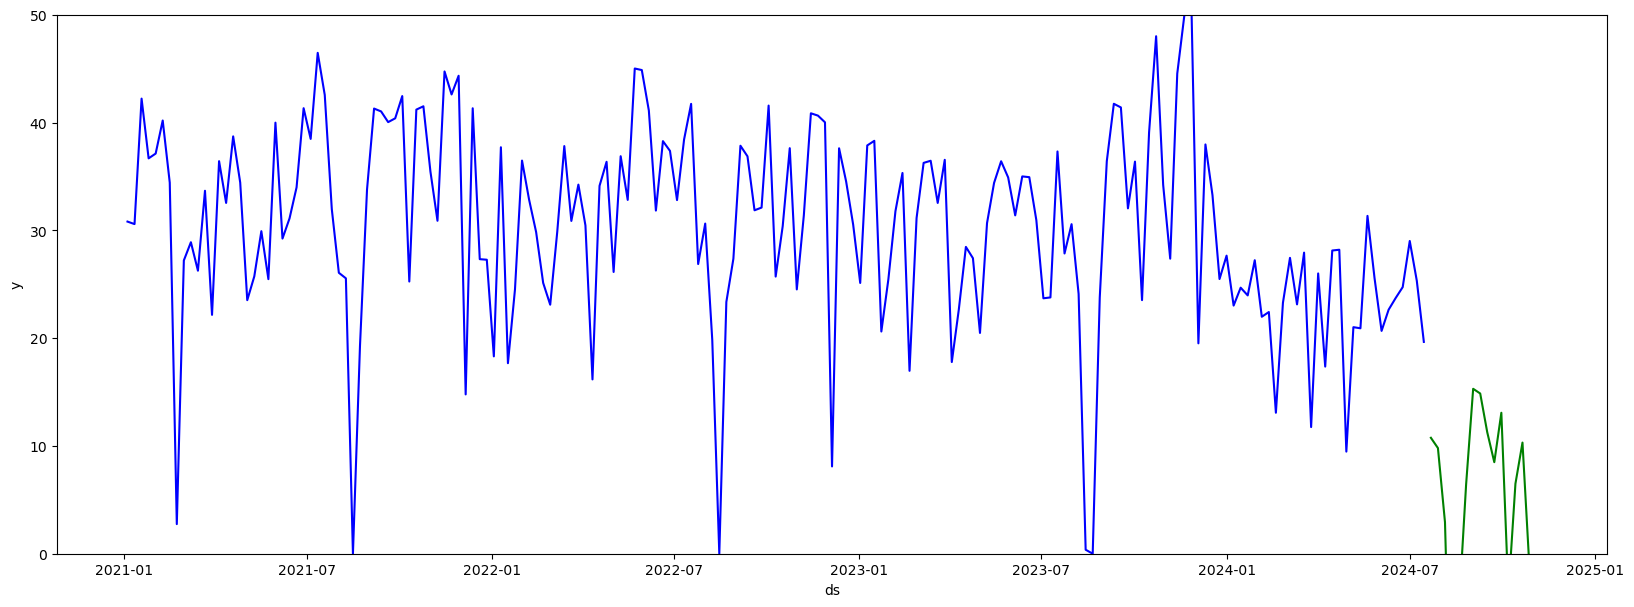

In [20]:
#Predicciones Futuras

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    df_exponential_smoothing['y'], 
    trend='add', #mul
    seasonal='add', #mul
    seasonal_periods=52
).fit(
    smoothing_level=best_alpha,  # Alpha
    smoothing_slope=best_beta,  # Beta
    smoothing_seasonal=best_gamma,  # Gamma
    optimized=False  # No optimizar automáticamente
 )

y_pred_exp = model.forecast(16)

data = {
    'ds': future_dates,
    'yhat': y_pred_exp
}

y_pred_exp = pd.DataFrame(data)

#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
sns.lineplot(data = df_exponential_smoothing, x= 'ds', y= 'y', color = 'blue')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'green')

## Búsqueda automática de hiperparámetros

RMSE: 5.001267092518416


<Axes: xlabel='ds', ylabel='y'>

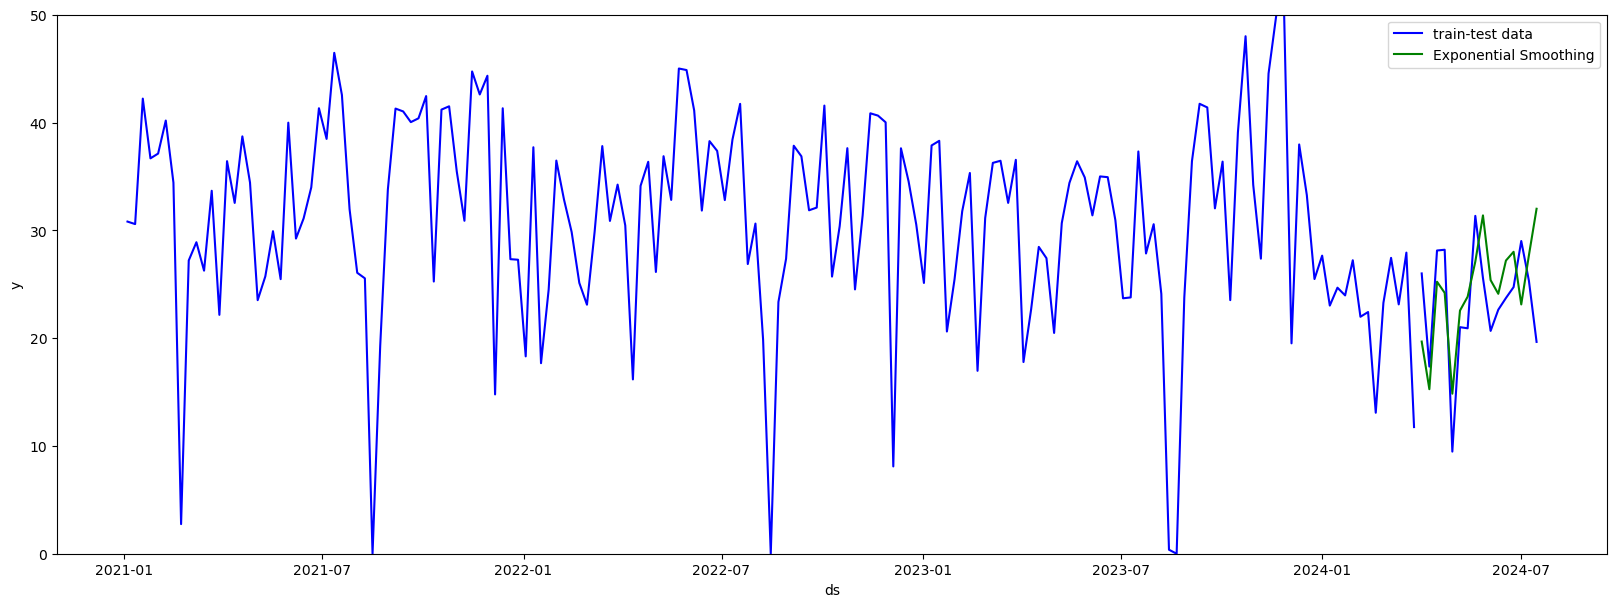

In [21]:
#Entrenar y realizar predicciones con los hiperparámetros calculados:
model = ExponentialSmoothing(
    df_exp_train['y'], 
    trend='add', #mul
    seasonal='add', #mul
    seasonal_periods=52
).fit(
    optimized= True  # No optimizar automáticamente
)

y_pred_exp = model.forecast(16)

data = { 
    'ds': df_exp_test['ds'],
    'yhat': y_pred_exp
}

y_pred_exp = pd.DataFrame(data)
rmse_exp = mean_squared_error(df_exp_test['y'], y_pred_exp['yhat']) ** (1/2)
print('RMSE: ' + str(rmse_exp))

#Trabajo Semanal
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
sns.lineplot(data = df_exp_train, x= 'ds', y= 'y', color = 'blue', label = 'train-test data')
sns.lineplot(data = df_exp_test, x= 'ds', y= 'y', color = 'blue')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'green', label = 'Exponential Smoothing')

In [12]:
alpha = model.params['smoothing_level']
beta = model.params['smoothing_trend']
gamma = model.params['smoothing_seasonal']

# Mostrar los valores calculados
print("Valor de alfa (smoothing_level):", alpha)
print("Valor de beta (smoothing_trend):", beta)
print("Valor de gamma (smoothing_seasonal):", gamma)

Valor de alfa (smoothing_level): 0.2013143242339837
Valor de beta (smoothing_trend): 1.4663249250398026e-09
Valor de gamma (smoothing_seasonal): 2.2735473501595266e-08


suma de errores: -17.8683583239947


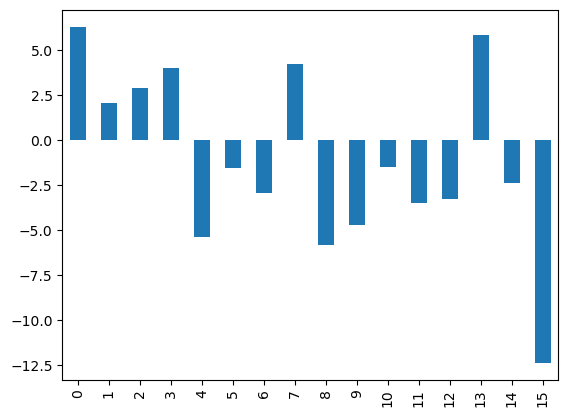

In [13]:
#Preparar dataset de comparación
df_forecast_comparison_exp = df_exp_test.merge(y_pred_exp, on= 'ds')
df_forecast_comparison_exp['error'] =  df_forecast_comparison_exp['y'] - df_forecast_comparison_exp['yhat']

df_forecast_comparison_exp['error'].plot(kind = 'bar')
print('suma de errores: ' + str(df_forecast_comparison_exp['error'].sum()))

In [14]:
#Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print ('RMSE Exponential Smoothing: ' + str(mean_squared_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat']) ** (1/2)))
print ('MAE Exponential Smoothing: ' + str(mean_absolute_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat'])))
print ('MAPE Exponential Smoothing: ' + str(mean_absolute_percentage_error(df_forecast_comparison_exp['y'], df_forecast_comparison_exp['yhat'])))

RMSE Exponential Smoothing: 5.001267092518416
MAE Exponential Smoothing: 4.296566182005961
MAPE Exponential Smoothing: 0.20303251467265804


## Predicciones de valores futuros (con hiperparámetros ajustados automáticamente)

In [15]:
last_date = fecha_max
future_dates = pd.date_range(start=last_date, periods=17, freq='W-MON')[1:]

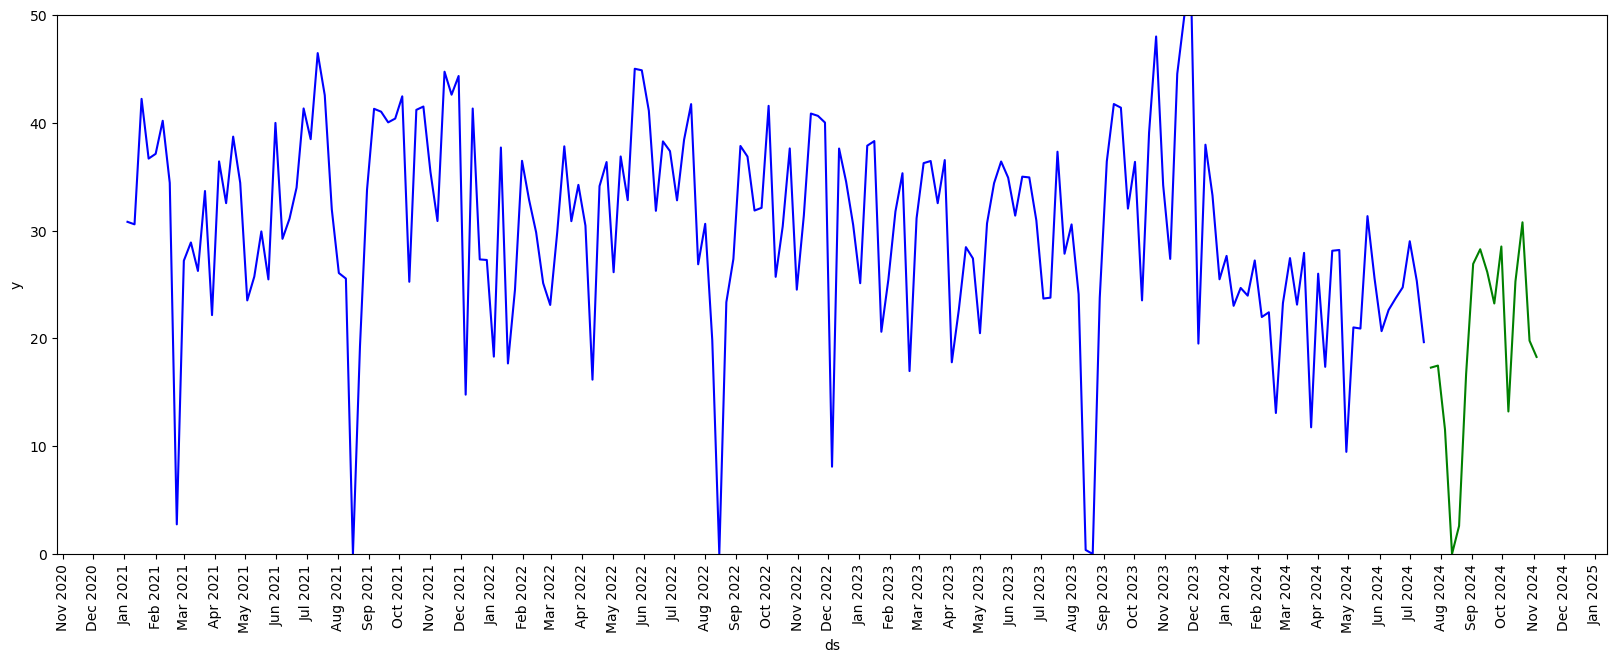

In [16]:
#Predicciones Futuras

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates

def limitar_cero(valor):
    if valor < 0:
        return 0
    else:
        return valor

model = ExponentialSmoothing(
    df_exponential_smoothing['y'], 
    trend='add', #mul
    seasonal='add', #mul
    seasonal_periods=52
).fit(
    optimized=True  # No optimizar automáticamente
 )

y_pred_exp = model.forecast(16)

data = {
    'ds': future_dates,
    'yhat': y_pred_exp
}

y_pred_exp = pd.DataFrame(data)

y_pred_exp['yhat'] = y_pred_exp['yhat'].apply(limitar_cero)

#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0,50)
plt.xticks(rotation=90)
sns.lineplot(data = df_exponential_smoothing, x= 'ds', y= 'y', color = 'blue')
sns.lineplot(data = y_pred_exp, x= 'ds', y= 'yhat', color = 'green')

ax.xaxis.set_major_locator(mdates.MonthLocator())  # Ubicar las etiquetas en cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Mostrar solo el nombre del mes

plt.show()

In [17]:
alpha = model.params['smoothing_level']
beta = model.params['smoothing_trend']
gamma = model.params['smoothing_seasonal']

# Mostrar los valores calculados
print("Valor de alfa (smoothing_level):", alpha)
print("Valor de beta (smoothing_trend):", beta)
print("Valor de gamma (smoothing_seasonal):", gamma)

Valor de alfa (smoothing_level): 0.18873413241034206
Valor de beta (smoothing_trend): 6.196900677075345e-10
Valor de gamma (smoothing_seasonal): 1.1451704082523024e-08


In [18]:
y_pred_exp.to_excel('./predictions/y_pred_exp.xlsx')